# Air Passengers forcasting using Time Series Analysis - ARIMA model

- Dataset: AirPassengers.csv
- Kaggle Competition

Time Series is a series of observations taken at specified time intervals usually equal intervals. Analysis of the series helps us to predict future values based on previous observed values. In Time series, we have only 2 variables, time & the variable we want to forecast.

# Setup

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.pylab import rcParams
from datetime import datetime
warnings.filterwarnings('ignore')

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [25]:
sns.set_style('darkgrid')

In [26]:
rcParams['figure.figsize'] = 10,6

# Load data

In [27]:
df = pd.read_csv('/home/dhanya/Projects/Time Series/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [13]:
df['Month'] = pd.to_datetime(df['Month'])

In [14]:
df.set_index('Month', inplace = True)

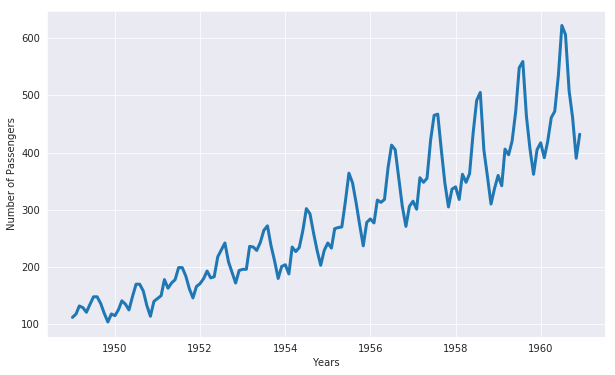

In [15]:
plt.plot(df['#Passengers'], linewidth = 3)
plt.xlabel('Years')
plt.ylabel('Number of Passengers')
plt.show()

In [16]:
#Now the rolling statistics
rolmean = df.rolling(window= 12).mean() #Gives a series of means of the number of previous values equals the window size.
print(rolmean.head(20))
rolstd = df.rolling(window=12).std()
print(rolstd.head(20))

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01   126.666667
1950-01-01   126.916667
1950-02-01   127.583333
1950-03-01   128.333333
1950-04-01   128.833333
1950-05-01   129.166667
1950-06-01   130.333333
1950-07-01   132.166667
1950-08-01   134.000000
            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01    13.720147
1950-01-01    13.453342
1950-02-01    13.166475
1950-03-01    13.686977
1950-04-01    13.822467
1950-05-01    13.663710
1950-06-01    14

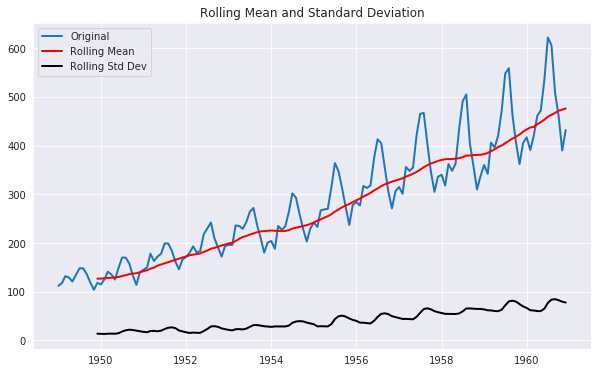

In [17]:
plt.plot(df['#Passengers'], linewidth = 2, label = 'Original')
plt.plot(rolmean, linewidth = 2, label = 'Rolling Mean', color = 'r')
plt.plot(rolstd, linewidth = 2, label = 'Rolling Std Dev', color = 'k')
plt.legend(loc = 'best')
plt.title('Rolling Mean and Standard Deviation')
plt.show()

From the above plot it is clear that although our rolling standard deviation is almost constant but our rolling mean has a trend.
Our time-series in order to be stationary both rolling statistics are required to be parallel to the x-axis.

In order to support our argument we can conduct the ACDF hypothesis testing.

In [18]:
#Performing Augumented Dickey Fuller Test
print('Results of the Dickey Fuller Test')
dftest = adfuller(x = df['#Passengers'], autolag= 'AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)
for key,value in dftest[4].items():
    print('Critical Value ({}) = {}'.format(key,value))

Results of the Dickey Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64
Critical Value (1%) = -3.4816817173418295
Critical Value (5%) = -2.8840418343195267
Critical Value (10%) = -2.578770059171598


Null Hypothesis : The time-series is not stationary.

From the above results we can see that our p-value is much larger than any of the critical values.
And none of the Critical Values are near to our Test Statistic.
So we keep the Null Hypothesis.

According to the ACDF test, our time-series at the moment is not stationary.



## Transforming to Stationary
Several methods to make our time-series stationary are stationarity through data transformation like taking log10,loge, square, square root, cube, cube root, exponential decay, time shift, etc.

Opting for the log transformations¶

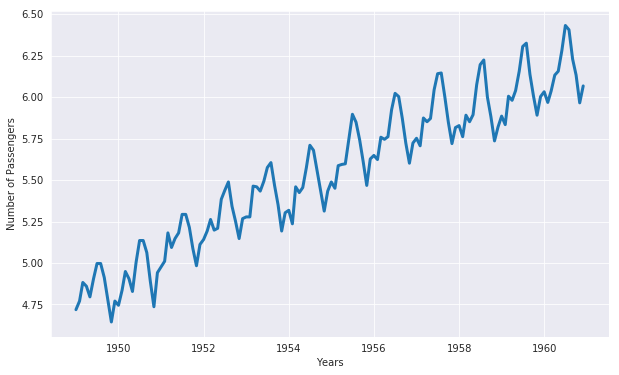

In [19]:
df_log = np.log(df)
plt.plot(df_log['#Passengers'], linewidth = 3)
plt.xlabel('Years')
plt.ylabel('Number of Passengers')
plt.show()

Although the plot seems similar to the previous one but the scale has changed.

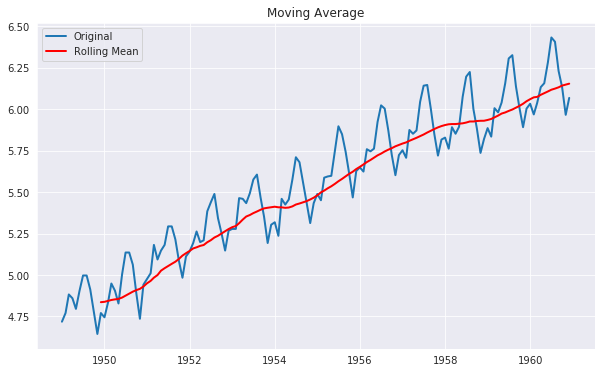

In [20]:
#Tranformation to make stationary
movingAverage = df_log.rolling(window= 12).mean()
movingStd = df_log.rolling(window=12).std()
plt.plot(df_log['#Passengers'], linewidth = 2, label = 'Original')
plt.plot(movingAverage, linewidth = 2, label = 'Rolling Mean', color = 'r')
plt.legend(loc = 'best')
plt.title('Moving Average')
plt.show()

The rolling mean is still not much stationary but atleast better than previous case.



We know from above graph that both the Time series with log scale as well as its moving average have a trend component.

logscaleL=stationarypart(L1)+trend(LT)
 
movingavgoflogscaleA=stationarypart(A1)+trend(AT)
 
resultseriesR=L−A=(L1+LT)−(A1+AT)=(L1−A1)+(LT−AT)
 

Since, L & A are series & it moving avg, their trend will be more or less same, Hence LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have,

R=L1−A1 , our final non-trend curve



In [21]:
dfLogScaleMinusMovingAverage = df_log - movingAverage
#Removing the NaN Values
dfLogScaleMinusMovingAverage.dropna(inplace= True)


In [22]:
def test_stationary(timeseries):
    #Determining Rolling Statistics
    movingAverage = timeseries.rolling(window = 12).mean()
    movingStd = timeseries.rolling(window = 12).std()
    
    #Plotting Rolling Statistics
    plt.plot(timeseries, linewidth = 2, label = 'Original')
    plt.plot(movingAverage, linewidth = 2, label = 'Rolling Mean', color = 'r')
    plt.plot(movingStd, linewidth = 2, label = 'Rolling Std Dev', color = 'k')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    #Performing Dickey Fuller Test
    #Performing Augumented Dickey Fuller Test
    print('Results of the Dickey Fuller Test')
    dftest = adfuller(x = timeseries['#Passengers'], autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)
    for key,value in dftest[4].items():
        print('Critical Value ({}) = {}'.format(key,value))

In [20]:
def test_stationary(timeseries):
    #Determining Rolling Statistics
    movingAverage = timeseries.rolling(window = 12).mean()
    movingStd = timeseries.rolling(window = 12).std()
    
    #Plotting Rolling Statistics
    plt.plot(timeseries, linewidth = 2, label = 'Original')
    plt.plot(movingAverage, linewidth = 2, label = 'Rolling Mean', color = 'r')
    plt.plot(movingStd, linewidth = 2, label = 'Rolling Std Dev', color = 'k')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    #Performing Dickey Fuller Test
    #Performing Augumented Dickey Fuller Test
    print('Results of the Dickey Fuller Test')
    dftest = adfuller(x = timeseries['#Passengers'], autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)
    for key,value in dftest[4].items():
        print('Critical Value ({}) = {}'.format(key,value))

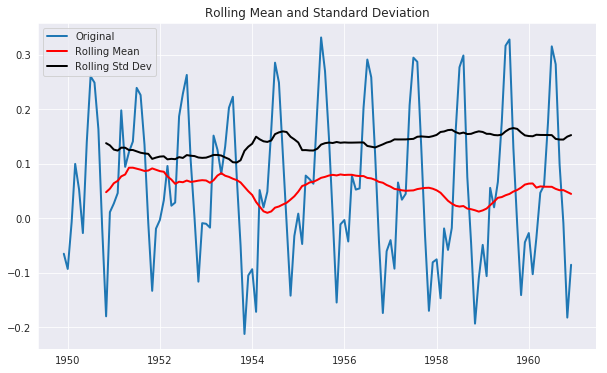

Results of the Dickey Fuller Test
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
dtype: float64
Critical Value (1%) = -3.4865346059036564
Critical Value (5%) = -2.8861509858476264
Critical Value (10%) = -2.579896092790057


In [21]:
test_stationary(dfLogScaleMinusMovingAverage)

The above process shows that "Subtracting two similar trend series can make the series stationary"
p-values has reduced frmom 0.99 to 0.022
Critical-values are pretty close to test statistic.  
From these conditions we cansay that our given series is stationary.  

For the purpose of getting higher accuracy we try to find better scale than our current log scale.  




#### Exponential Decay

In [22]:
exDecayWeightedAverage = df_log.ewm(halflife= 12, min_periods=0, adjust= True).mean()

[pandas.DataFrame.ewm](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html)

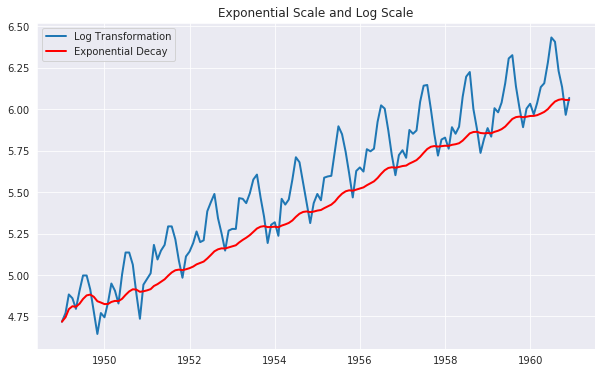

In [23]:
plt.plot(df_log, linewidth = 2, label = 'Log Transformation')
plt.plot(exDecayWeightedAverage, linewidth = 2, color = 'r', label = 'Exponential Decay')
plt.title("Exponential Scale and Log Scale")
plt.legend()
plt.show()

The above plot shows not much difference in log scale and Exponential decay transformation  
but we also conduct the ACDF test to back our observation.

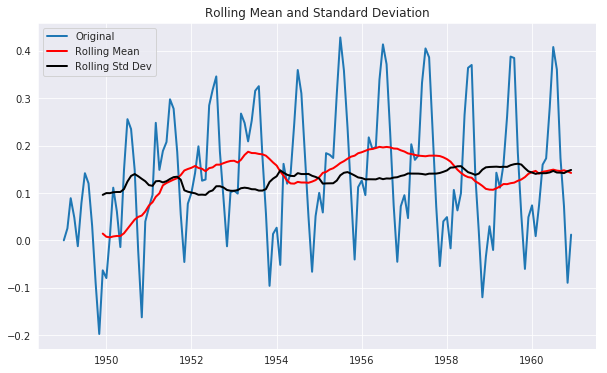

Results of the Dickey Fuller Test
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64
Critical Value (1%) = -3.4816817173418295
Critical Value (5%) = -2.8840418343195267
Critical Value (10%) = -2.578770059171598


In [24]:
dfLogScaleMinusExpoMovingAverage =  df_log - exDecayWeightedAverage
test_stationary(dfLogScaleMinusExpoMovingAverage)

We can observe that the time series is stationary since the sries is almost parallel to the x-axis.

p-value has decreased from 0.02 to 0.005  
Test Statistical Values is much closer to the critical values.  

As visually it couldn't be observed but our new transformation is better than our log transformation.
  

_____

We can try even to get even better results by using the simple time shift technique.  

Given the values:  
$$x0, x1, x2, x3, .... xn$$  
Shifted values will be  
$$null, x0, x1, x2,.... xn$$  
Thus, the time series with time shifted values are:  
$$null, (x1-x0), (x2-x1), (x3-x2), (x4-x3),.... (xn-x_{n-1})$$

#### Time - Shift Transformation

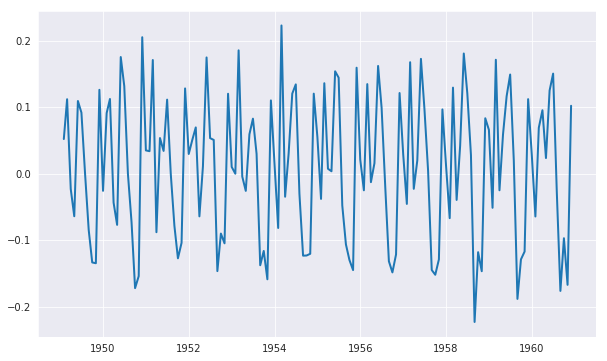

In [25]:
dfLogTimeShift = df_log.shift()
dfLogDiffShift = df_log - dfLogTimeShift 
plt.plot(dfLogDiffShift, linewidth = 2)
plt.show()

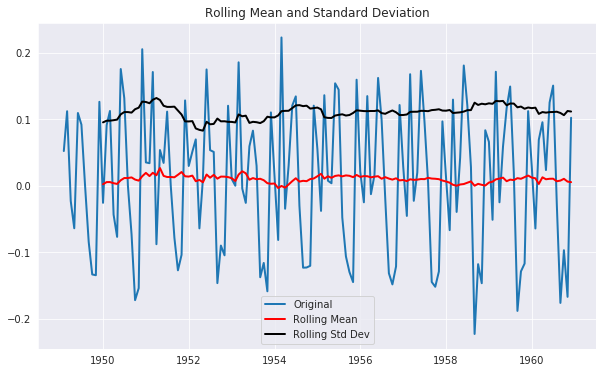

Results of the Dickey Fuller Test
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
dtype: float64
Critical Value (1%) = -3.4825006939887997
Critical Value (5%) = -2.884397984161377
Critical Value (10%) = -2.578960197753906


In [26]:
dfLogDiffShift.dropna(inplace= True)
test_stationary(dfLogDiffShift)

Visually it looks like the best result but as the ACDF Test shows us that it is not better than our Exponential Decay.  
Although we got the best results in Exponential Decay but we will continue with log transformation for simplicity.

_____

Now we break down the three components of the log scale series using a library function. Once we separate out the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

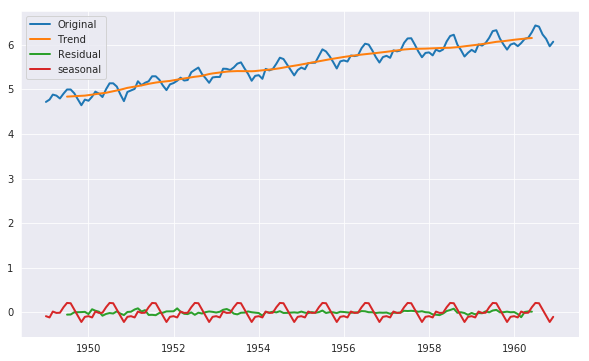

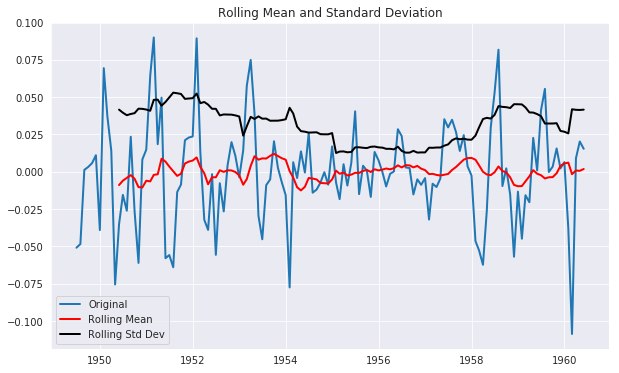

Results of the Dickey Fuller Test
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
dtype: float64
Critical Value (1%) = -3.4851223522012855
Critical Value (5%) = -2.88553750045158
Critical Value (10%) = -2.5795685622144586


In [27]:
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.plot(df_log, label = 'Original', linewidth = 2)
plt.plot(trend, label = 'Trend', linewidth = 2)
plt.plot(residual, label = 'Residual', linewidth = 2)
plt.plot(seasonal,label = 'seasonal', linewidth = 2)
plt.legend()
plt.show()

decomposedLog = residual
decomposedLog.dropna(inplace = True)
test_stationary(decomposedLog)

___

### Plotting ACF and PACF

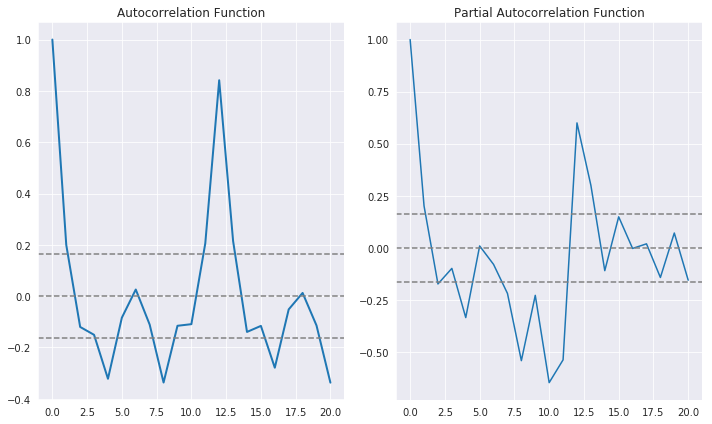

In [28]:
lag_acf = acf(dfLogDiffShift, nlags = 20)
lag_pacf = pacf(dfLogDiffShift, nlags = 20, method= 'ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf, linewidth = 2)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(dfLogDiffShift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dfLogDiffShift)), linestyle='--', color='gray')
plt.title('Autocorrelation Function') 

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dfLogDiffShift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dfLogDiffShift)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 



From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model

______

## Building Models

#### AR Model

Plotting AR model


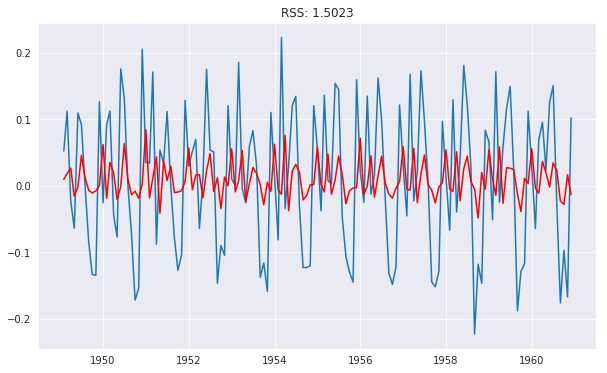

In [29]:
model = ARIMA(df_log, order=(2,1,0))
results_AR = model.fit(disp = -1)
plt.plot(dfLogDiffShift)
plt.plot(results_AR.fittedvalues, color = 'r')
plt.title('RSS: {:.4f}'.format(sum((results_AR.fittedvalues - dfLogDiffShift['#Passengers'])**2)))
print('Plotting AR model')

#### MA model

Plotting MA model


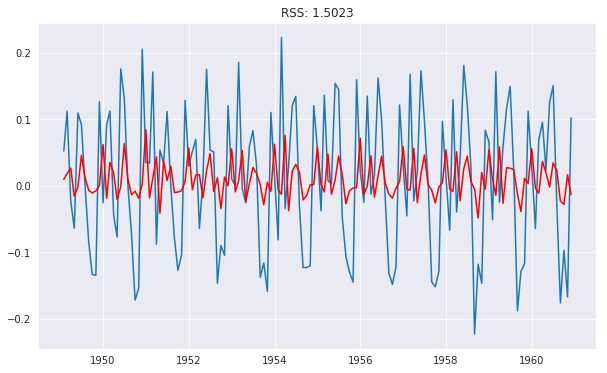

In [30]:
model = ARIMA(df_log, order=(0,1,2))
results_MA = model.fit(disp = -1)
plt.plot(dfLogDiffShift)
plt.plot(results_AR.fittedvalues, color = 'r')
plt.title('RSS: {:.4f}'.format(sum((results_AR.fittedvalues - dfLogDiffShift['#Passengers'])**2)))
print('Plotting MA model')

Plotting ARIMA model


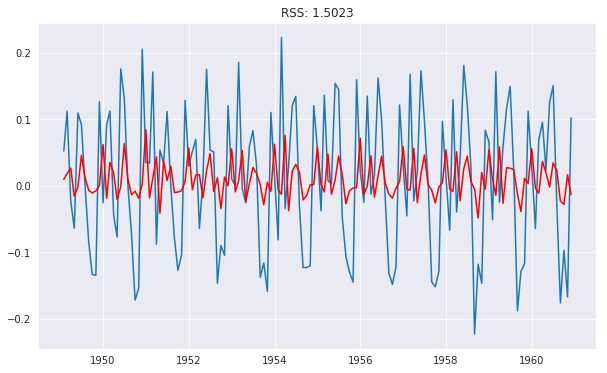

In [31]:
model = ARIMA(df_log, order=(2,1,2))
results_ARIMA = model.fit(disp = -1)
plt.plot(dfLogDiffShift)
plt.plot(results_AR.fittedvalues, color = 'r')
plt.title('RSS: {:.4f}'.format(sum((results_AR.fittedvalues - dfLogDiffShift['#Passengers'])**2)))
print('Plotting ARIMA model')

Bu using the ARIMA model we can observe that the RSS values has reduced from both cases to 1.0292.  
This implies that the ARIMA model is better than both the AR and MA individually.  
Now with our model we can make predictions but first we need to convert the predictions back in original form, beacuse our model is built on Log tranformed data.

### Predictions and Revert Conversions

In [32]:
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy= True)
print(predictions_ARIMA.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [33]:
#Convet to cumulative sum
predictions_ARIMA_cumsum = predictions_ARIMA.cumsum()
predictions_ARIMA_cumsum.head(10)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
1949-07-01    0.021984
1949-08-01    0.011007
1949-09-01   -0.018922
1949-10-01   -0.053389
1949-11-01   -0.064668
dtype: float64

In [34]:
predictions_ARIMA_log = pd.Series(df_log['#Passengers'].iloc[0], index = df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_cumsum, fill_value = 0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

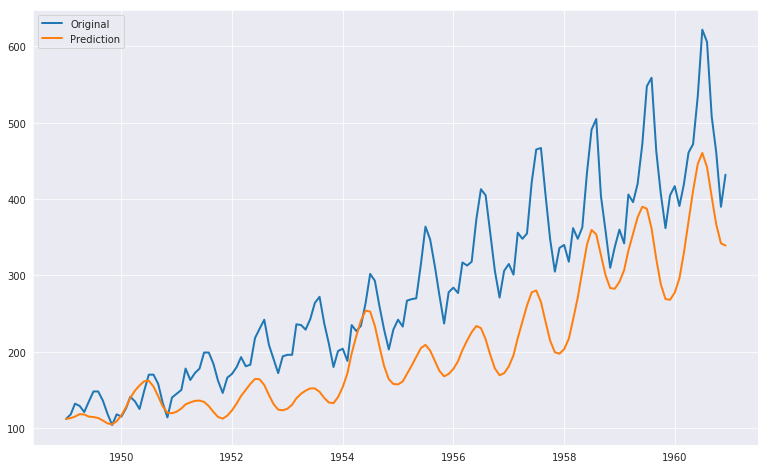

In [35]:
#Inverse of log is exponent
plt.figure(figsize=(13,8))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df, linewidth = 2, label = 'Original')
plt.plot(predictions_ARIMA, linewidth = 2, label = 'Prediction')
plt.legend()
plt.show()

We can see that we have got a fairly accurate model.

In [36]:
df_log

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


We have 144 data points and we want to predict additional 10 years data which suggest we have to predict additional 120 points.

<Figure size 936x576 with 0 Axes>

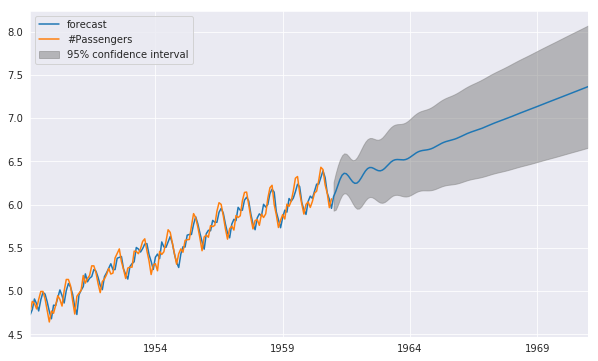

In [37]:
plt.figure(figsize=(13,8))
results_ARIMA.plot_predict(1,264)
plt.legend(loc = 'upper left')
plt.show()

______